In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os

from google.cloud import bigquery
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eduardchai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Create BQ Client

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/eduardchai/Workspace/NUS/eb5001-big-data-for-analytics/CA/big-data-ca-svc-acc.json"

In [4]:
client = bigquery.Client()

## Load data

In [5]:
sql = """
    SELECT *
    FROM `big-data-project-272506.yelp_dataset.restaurant_reviews_labeled`
"""

# Run a Standard SQL query using the environment's default project
df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = 'big-data-project-272506'
df = client.query(sql, project=project_id).to_dataframe()

In [6]:
df.loc[df.flagged == True, "flagged"] = 'Y'
df.loc[df.flagged == False, "flagged"] = 'N'

In [7]:
df.columns

Index(['review_id', 'reviewer_id', 'restaurant_id', 'timestamp', 'rating',
       'review_content', 'friend_count', 'review_count', 'useful_count',
       'cool_count', 'funny_count', 'restaurant_rating', 'review_length',
       'rating_deviation', 'maximum_review_per_user', 'cos_sim', 'flagged'],
      dtype='object')

## Fake Reviews Word Cloud

In [8]:
fake = df[df['flagged'] == 'Y' ]
len(fake)

6206

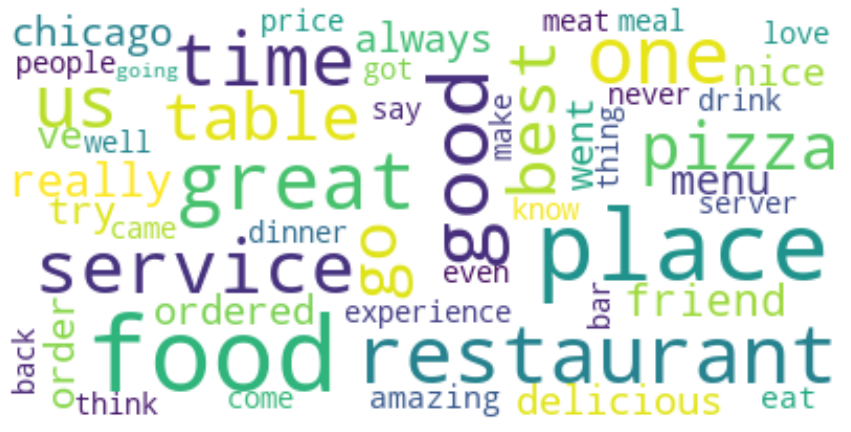

In [9]:
fake_reviews = ' '.join(fake['review_content'].head(1000))

wordcloud = WordCloud().generate(fake_reviews)
# Display the generated image:

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(fake_reviews)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis of Fake Reviews

In [10]:
def clean_text(text):
    # lower text
    text = str(text).lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [11]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
fake["review_clean"] = fake["review_content"].apply(lambda x: clean_text(x))

sia = SentimentIntensityAnalyzer()
fake["sentiments"] = fake["review_clean"].apply(lambda x: sia.polarity_scores(x))
fake_reviews = pd.concat([fake.drop(['sentiments'], axis=1), fake['sentiments'].apply(pd.Series)], axis=1)

In [13]:
fake["neg_sent_score"] = fake["sentiments"].apply(lambda x: x.get('neg')) 
fake["pos_sent_score"] = fake["sentiments"].apply(lambda x: x.get('pos'))
fake["neu_sent_score"] = fake["sentiments"].apply(lambda x: x.get('neu'))
fake["sum_of_sent_scores"] = fake["sentiments"].apply(lambda x: x.get('compound'))

count    6206.000000
mean        0.058637
std         0.077558
min         0.000000
25%         0.000000
50%         0.034000
75%         0.090000
max         1.000000
Name: neg_sent_score, dtype: float64

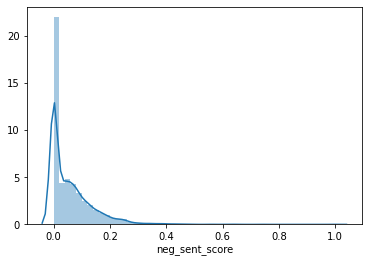

In [14]:
import seaborn as sns
sns.distplot(fake["neg_sent_score"])
fake["neg_sent_score"].describe()

count    6206.000000
mean        0.365104
std         0.164205
min         0.000000
25%         0.251000
50%         0.355000
75%         0.467000
max         1.000000
Name: pos_sent_score, dtype: float64

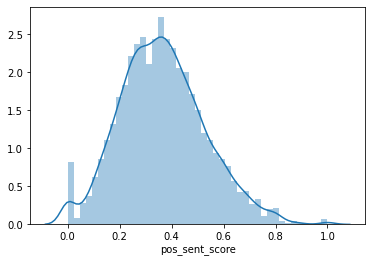

In [15]:
sns.distplot(fake["pos_sent_score"])
fake["pos_sent_score"].describe()

### Conclusion: Majority of the fake reviews are positive reviews used to boost business reputation.

## Real Reviews Word Cloud and Analysis 

In [16]:
real = df[df['flagged'] == 'N' ]
len(real)

20752

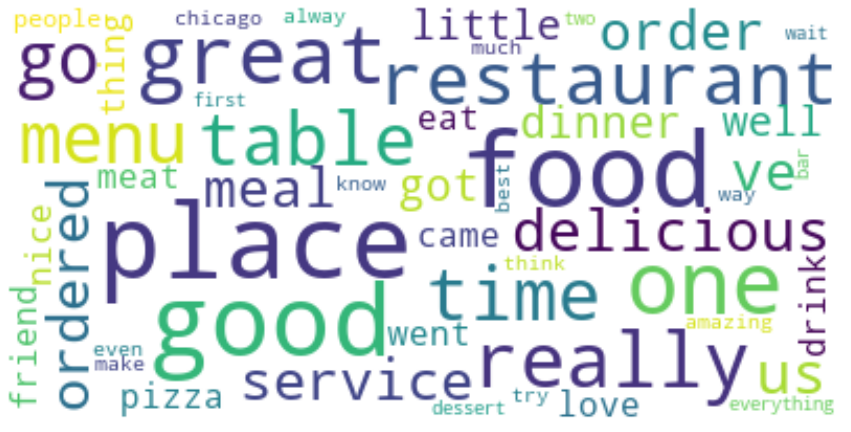

In [17]:
real_reviews = ' '.join(real['review_content'].head(1000))

wordcloud = WordCloud().generate(real_reviews)
# Display the generated image:

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(real_reviews)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis of Real Reviews

In [18]:
real["review_clean"] = real["review_content"].apply(lambda x: clean_text(x))

sia = SentimentIntensityAnalyzer()
real["sentiments"] = real["review_clean"].apply(lambda x: sia.polarity_scores(x))
real_reviews = pd.concat([real.drop(['sentiments'], axis=1), real['sentiments'].apply(pd.Series)], axis=1)

In [19]:
real["neg_sent_score"] = real["sentiments"].apply(lambda x: x.get('neg')) 
real["pos_sent_score"] = real["sentiments"].apply(lambda x: x.get('pos'))
real["neu_sent_score"] = real["sentiments"].apply(lambda x: x.get('neu'))
real["sum_of_sent_scores"] = real["sentiments"].apply(lambda x: x.get('compound'))

count    20752.000000
mean         0.056295
std          0.063420
min          0.000000
25%          0.000000
50%          0.043000
75%          0.084000
max          1.000000
Name: neg_sent_score, dtype: float64

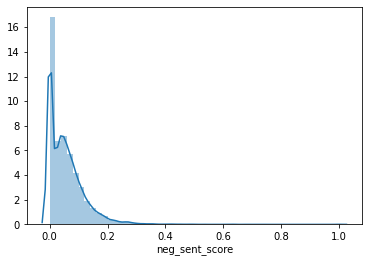

In [20]:
import seaborn as sns
sns.distplot(real["neg_sent_score"])
real["neg_sent_score"].describe()

count    20752.000000
mean         0.334851
std          0.131022
min          0.000000
25%          0.249000
50%          0.324000
75%          0.409000
max          1.000000
Name: pos_sent_score, dtype: float64

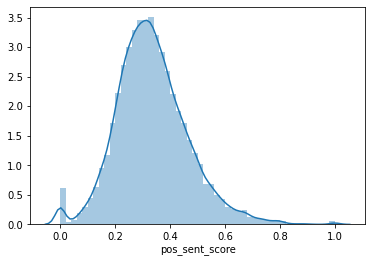

In [21]:
sns.distplot(real["pos_sent_score"])
real["pos_sent_score"].describe()